# Task 1

## Multinomial Logistic Regression

Implement a Multinomial logistic regression model from scratch using numpy
and pandas. You have to train this model on Wine Quality Dataset to classify
a wine’s quality based on the values of its various contents

In [ ]:
import os
import wandb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler

### Task 1.1

In [ ]:
PATH = './dataset/WineQT.csv'
df = pd.read_csv(PATH)
# drop the Id column
df = df.drop('Id', axis=1)
df.head()

In [ ]:
# choose man std min and max from df.describe()
df.describe().loc[['mean', 'std', 'min', 'max']]

In [ ]:
plt.figure(figsize=(20, 20))
plt.subplot(4, 3, 1)
for i, col in enumerate(df.columns):
    plt.subplot(4, 3, i+1)
    sns.histplot(df[col], kde=True, color='blue', edgecolor='black')
    plt.title(col).set_color('red')


In [ ]:
# check for missing values
df.isnull().sum()

## No Missing Values

In [ ]:
df.head()

In [ ]:
# scaler = StandardScaler()
# df_scaled = scaler.fit_transform(df.drop('quality', axis=1).values)
# df_scaled = pd.DataFrame(df_scaled, columns=df.columns[:-1])
# # df_scaled[:,:5]


# df_scaled.describe()


In [ ]:
# standardize the data except the target column 'quality'
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df.drop('quality', axis=1))
df_scaled = pd.DataFrame(df_scaled, columns=df.columns[:-1])

quality_min = df['quality'].min()
# print(quality_min)
df_scaled['quality'] = df['quality'].apply(lambda x: x - quality_min)
# df_scaled.head()
df_scaled.describe().loc[['mean', 'std', 'min', 'max']]

In [ ]:
plt.figure(figsize=(12, 6))
corr = df_scaled.corr()
sns.heatmap(corr, annot=True, cmap=plt.cm.Reds)

In [ ]:
# plot the correlation matrix of df_scaled


In [ ]:
df_scaled.shape

In [ ]:
pca = PCA(n_components=11)
df_pca = pca.fit_transform(df_scaled.drop('quality', axis=1))
# df_pca = pca.transform(df_scaled.drop('quality', axis=1))
df_pca = pd.DataFrame(df_pca, columns=df.columns[:-1])

df_pca['quality'] = df_scaled['quality']

# one hot encode the quality column
df_pca = pd.get_dummies(df_pca, columns=['quality'])
df_pca.head()
# print the explained variance ratio
print('Explained variance ratio: ', pca.explained_variance_ratio_)

In [ ]:
X = df_pca[['PC1', 'PC2']].values
y = df_pca[['quality_0', 'quality_1', 'quality_2', 'quality_3', 'quality_4', 'quality_5']].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [ ]:
plt.scatter(X_train[:, 0], X_train[:, 1])

In [ ]:
# X_train[:5]
# y_train[:5]
# X_test[:5]
# y_test[:5]
# y_test[y_test[:, 0] == 1].shape

$\mathbf{x^{(i)}} = [x_1^{(i)}, x_2^{(i)}, \dots, x_f^{(i)}]$

*foreach* $\;\;\;\mathbf{x}^{(i)}\;\; \text{in input}\;\; [x^{(1)}, x^{(2)}, ..., x^{(m)}]$

$\;\;\;\;\;\;\;\;\;\;\;\;\;\;y^{(i)} = \sigma(w^T x^{(i)} + b)$

First, we’ll pack all the input feature vectors for each input $\mathbf{x^{(i)}}$ into a single input
matrix $\mathbf{X}$, where each row $i$ is a row vector consisting of the feature vector for input example $\mathbf{x^{(i)}}$
Assuming each example has f features and
weights, X will therefore be a matrix of shape [m× f ], as follows:

$$
X =
\begin{bmatrix}
x^{(1)}_1 & x^{(1)}_2 & \ldots & x^{(1)}_f \\
x^{(2)}_1 & x^{(2)}_2 & \ldots & x^{(2)}_f \\
\vdots & \vdots & \ddots & \vdots \\
x^{(m)}_1 & x^{(m)}_2 & \ldots & x^{(m)}_f \\
\end{bmatrix}
$$

Now if we introduce $b$ as a vector of length $m$ which consists of the scalar bias term $b$ repeated $m$ times, $b = [b,b,...,b]$, and $\hat{y} = [\hat{y}^{(1)}, \hat{y}^{(2)},..., \hat{y}^{(m)}]$ as the vector of outputs (one scalar $\hat{y}^{(i)}$ for each input $x^{(i)}$ and its feature vector $x^{(i)}$), and represent the weight vector $w$ as a column vector, we can compute all the outputs with a single matrix multiplication and one addition:

$$\hat{y} = Xw + b$$

You should convince yourself that Eq. 5.12 computes the same thing as our for-loop in Eq. 5.10. For example $\hat{y}^{(1)}$, the first entry of the output vector $y$, will correctly be:

$$\hat{y}^{(1)} = [x^{(1)}_1, x^{(1)}_2,...,x^{(1)}_f] \cdot [w_1,w_2,...,w_f] + b$$

### Task 1.2

### Using Mini Batch Stochastic Gradient Descent

In [ ]:
class MultiomialLogisticRegression:
    def __init__(self, lr=0.01, epochs=2000, batch_size=32):
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        
    def init_params(self, X, y):
        self.weights = np.random.randn(y.shape[1], X.shape[1]) # (no of classes, no of features)
        self.k = y.shape[1]
        self.n = X.shape[0]
        self.m = X.shape[1]
        
    def fit(self, X, y, X_val=None, y_val=None):
        X = np.insert(X, 0, 1, axis=1) # insert 1 for bias
        
        self.init_params(X, y)
        
        self.loss = []
        self.accuracy = []
        for i in range(self.epochs):
            # Shuffle the data
            indices = np.random.permutation(self.n)
            X_shuffled = X[indices]
            y_shuffled = y[indices]
            
            # Split the data into batches
            for j in range(0, self.n, self.batch_size):
                X_batch = X_shuffled[j:j+self.batch_size]
                y_batch = y_shuffled[j:j+self.batch_size]
                
                # Calculate the gradient and update the weights
                soft = self.softmax(self.calculate_z(X_batch))
                grad = self.gradient(X_batch, y_batch, soft)
                self.weights -= self.lr * grad
            
            # Calculate the loss and store it
            soft = self.softmax(self.calculate_z(X))
            self.loss.append(self.cross_entropy_loss(y, soft))
            # print(f"Epoch {i+1}: loss = {self.loss[-1]}")
            # print(X_val.shape)
            if X_val is not None and y_val is not None:
                y_pred = self.predict(X_val)
                # print(y_pred[:5])
                
                # print(y_pred.shape)
                self.accuracy.append(accuracy_score(y_true = np.argmax(y_val , axis=1), y_pred= y_pred))
                # print(self.accuracy[-1])
                # print(classification_report(y_true = np.argmax(y_val , axis=1), y_pred= y_pred, zero_division=1))
                
        # return self.weights, self.loss
    
    def softmax(self, z):
        z -= np.max(z, axis=1, keepdims=True) # for numerical stability
        return np.exp(z) / np.sum(np.exp(z), axis=1, keepdims=True)
    
    def calculate_z(self, X):
        return np.dot(X, self.weights.T)
    
    def cross_entropy_loss(self, y, y_hat):
        loss = -np.sum(y * np.log(y_hat)) / y.shape[0]
        return loss
    
    def gradient(self, X, y, y_hat):
        grad = np.dot((y_hat - y).T, X) / X.shape[0]
        return grad

    def predict(self, X):
        X = np.insert(X, 0, 1, axis=1)
        z = self.calculate_z(X)
        y_pred = np.argmax(self.softmax(z), axis=1)
        # print(y_pred.shape)
        return y_pred

MLR = MultiomialLogisticRegression(epochs=2000)
MLR.fit(X_train, y_train, X_val, y_val)
# MLR.fit(X_train, y_train)

In [ ]:
sns.set_style('darkgrid')
sns.lineplot(x=range(MLR.epochs), y=MLR.loss)
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
if len(MLR.accuracy) > 0:
    print("Maximum Accuracy: ", max(MLR.accuracy)*100)
    sns.set_style("darkgrid")
    sns.lineplot(x=range(len(MLR.accuracy)), y=np.array(MLR.accuracy)*100)
    plt.title("Accuracy over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    # plt.ylim([0, 100])
    # plt.savefig("accuracy_plot.png", dpi=300)
    plt.show()

### Plot the decision boundary

In [ ]:
# get the limits of PC1 and PC2

x0_min, x0_max = X[:, 0].min() - 1, X[:, 0].max() + 1
x1_min, x1_max = X[:, 1].min() - 1, X[:, 1].max() + 1
h = 0.01

xx0, xx1 = np.meshgrid(np.arange(x0_min, x0_max, h), np.arange(x1_min, x1_max, h))

X_new = np.c_[xx0.ravel(), xx1.ravel()]
# X_new.shape
y_pred = MLR.predict(X_new)
# y_pred.shape
# y_pred[:5]
# y_pred.reshape(xx0.shape).shape
plt.contourf(xx0, xx1, y_pred.reshape(xx0.shape), cmap=plt.cm.Accent, alpha=0.4)
scatter = plt.scatter(X_train[:, 0], X_train[:, 1], c=np.argmax(y_train, axis=1)+3, cmap=plt.cm.Accent, s=20)
plt.xlim(xx0.min(), xx0.max())
plt.ylim(xx1.min(), xx1.max())
plt.legend(*scatter.legend_elements())
plt.show()

### Task 1.3

In [ ]:
hyperparameter_defaults = dict(
    lr=[0.01, 0.001, 0.0001],
    epochs=[1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000],
)

wandb.init(project="multinomial-logistic-regression", name="Task 1 2 3.ipynb", config=hyperparameter_defaults)

config = wandb.config

best_accuracy = 0
for lr in config.lr:
    for epochs in config.epochs:
        MLR = MultiomialLogisticRegression(lr=lr, epochs=epochs)
        MLR.fit(X_train, y_train, X_val, y_val)
        if len(MLR.accuracy) > 0:
            accuracy = max(MLR.accuracy)*100
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_lr = lr
                best_epochs = epochs
            wandb.log({"lr": lr, "epochs": epochs, "accuracy": accuracy, "loss": MLR.loss[-1]})


In [ ]:
mlr = MultiomialLogisticRegression(lr=best_lr, epochs=best_epochs)
mlr.fit(X_train, y_train)
y_pred = mlr.predict(X_test)
print(classification_report(y_true = np.argmax(y_test , axis=1)+3, y_pred= y_pred+3, zero_division=1))
print("Accuracy: ", accuracy_score(y_true = np.argmax(y_test , axis=1)+3, y_pred= y_pred+3)*100)

In [ ]:
print(np.unique(np.argmax(y_test , axis=1)+3))

# Task 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from icecream import ic
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, r2_score

In [2]:
DEBUG = False

# Classes For Activation Functions

In [3]:
class Sigmoid: # Sigmoid Function:
    def __init__(self) -> None:
        pass
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    def activation(self, z):
        return self.sigmoid(z)
    def activation_derivative(self, s):
        # s = self.sigmoid(z)
        return s * (1 - s)


class Tanh: # Hyperbolic Tangent (Tanh) Function    
    def __init__(self) -> None:
        pass
    def activation(self, z):
        return np.tanh(z)
    
    def activation_derivative(self, t):
        # t = np.tanh(z)
        return 1 - t**2 

        
class ReLU: # Rectified Linear Unit (ReLU)
    def __init__(self) -> None:
        pass
    def activation(self, z):
        return np.maximum(0, z)
    
    def activation_derivative(self, z):
        return (z > 0)

class Identity:
    def __init__(self):
        pass

    def activation(self, z):
        # Linear activation function (identity function)
        return z

    def activation_derivative(self, z):
        # Derivative of the linear activation function is always 1
        # return np.ones_like(z)
        pass
    

# Used for Classification
class Softmax:
    def __init__(self) -> None:
        pass
    def activation(self, z):
        # print(z.shape)
        exps = np.exp(z - np.max(z))
        return exps / np.sum(exps, axis=1, keepdims=True)
    
    def activation_derivative(self, z):
        pass

# Classes For Loss Functions

In [4]:
class CrossEntropyLoss:
    def __init__(self, epsilon = 1e-15) -> None:
        self.epsilon = epsilon
    def loss(self, y_pred, y_true):
        epsilon = 1e-10
        loss = -np.sum(y_true * np.log(y_pred+epsilon)) / y_true.shape[0]
        return loss
    def gradient(self, y_pred, y_true):

        return ((y_pred - y_true) / y_true.shape[0])
    
class MSELoss:
    def __init__(self):
        pass

    def loss(self, y_pred, y_true):
        # Calculate the squared differences between predicted and true values
        squared_errors = (y_pred - y_true) ** 2
        # Compute the mean of squared errors
        mse = np.mean(squared_errors)
        return mse

    def gradient(self, y_pred, y_true):
        # Compute the gradient of the MSE loss
        gradient = 2 * (y_pred - y_true) / len(y_true)
        return gradient

# Classes For Layers

$$a^{(1)} = X$$
$$\hat{y} = a^{(L)} = \sigma(z^{(L)})$$
$$a^{(l) = \sigma(z^{(l)})}$$
$$z^{(l)} = W^{(l - 1)}$$
$$\delta^{(L)} = \hat{y} - y$$

### Recurrence Relation for $\delta^{(l)}$

$$\delta^{(l)} = \delta^{(l + 1)}(W^{(l)})^T \odot \sigma'(z^{(l)})$$


$$
   \frac{\partial J}{\partial W^{(l)}} = \frac{1}{m} \delta^{(l + 1)}(a^{(l)})^T
$$

In [5]:
class Layer:
    # no_of_neurons is equal to the no_of_output of the layer
    def __init__(self, no_of_inputs, no_of_neurons, activation) -> None:
        # use xavier initialization
        self.weights = np.random.randn(no_of_inputs, no_of_neurons) * np.sqrt(1 / no_of_inputs)
        self.bias = np.zeros((1, no_of_neurons))
        self.activation = activation
        
    def forward(self, inputs):
        self.inputs = inputs
        # self.inputs represents the activations of the previous layer a^{(l)}    

        
        self.a = self.activation.activation(np.dot(self.inputs, self.weights) + self.bias) 
        self.f_prime_z = self.activation.activation_derivative(self.a)
        return self.a
      
    
    def backward(self, delta, weights):
        # Element-wise multiplication for the derivative of the activation function
        
        # 1/m is already included in the gradient of the loss function
        delta = np.dot(delta, weights.T) * self.f_prime_z
                
        self.dj_dw = np.dot(self.inputs.T, delta)
        self.dj_db = np.sum(delta, axis=0, keepdims=True)
        
        
        return delta
    
    def update_weights(self, learning_rate):
        # Update weights and bias
        self.weights -= learning_rate * self.dj_dw
        self.bias -= learning_rate * self.dj_db
    
class InputLayer:
    def __init__(self, input_size) -> None: # input_size is unnecessary here
        self.f_prime_z = None
        self.weights = None
    def forward(self, inputs):
        # Forward pass for the input layer is just passing the input data
        return inputs

    def backward(self, delta):
        # The input layer has no weights, so the gradient is not modified
        return delta
    def update_weights(self, learning_rate):
        pass

class OutputLayer:
    def __init__(self, no_of_inputs, no_of_neurons, activation) -> None:
        self.weights = np.random.randn(no_of_inputs, no_of_neurons) * np.sqrt(1 / no_of_inputs)
        self.bias = np.zeros((1, no_of_neurons))
        self.f_prime_z = None
        self.activation = activation
        # ic(activation)
        
        # ic(self.weights.shape)
        
        # if no_of_neurons == 1:
        #     self.activation = Identity()
        # else:
        #     self.activation = Softmax()
            
    def forward(self, inputs):
        self.inputs = inputs
        # self.z = np.dot(self.inputs, self.weights)
        # self.a = self.activation.activation(np.dot(self.inputs, self.weights))
        self.a = self.activation.activation(np.dot(self.inputs, self.weights)+self.bias)
        return self.a
    
    def backward(self, delta):
        # grad_output is the gradient of the loss function with respect to the output of the layer
        # The gradient of the loss with respect to the input of the layer
        
        # self.dzdW = inputs.T
        # basically self.inputs.T is the same as self.dzdW
        self.dj_dw = np.dot(self.inputs.T, delta)
        self.dj_db = np.sum(delta, axis=0, keepdims=True)
        
        # grad_weights = np.dot(self.inputs.T, grad_output)
        # grad_bias = np.sum(grad_output, axis=0, keepdims=True)

        # The gradients of the loss with respect to the parameters of the layer
        
        # delta last layer
        return delta
    
    def update_weights(self, learning_rate):
        # Update weights and bias
        self.weights -= learning_rate * self.dj_dw
        self.bias -= learning_rate * self.dj_db
    
    # update will look something like this
    # def update(self, learning_rate):
    #     # Update weights and bias
    #     self.weights -= learning_rate * dj_dw
    #     self.bias -= learning_rate * self.grad_bias

In [27]:
class MLP:
    def __init__(self, input_size, hidden_layer_sizes, output_size,\
                 activation_function, output_activation_function, optimizer, loss, learning_rate = 0.001) -> None:
        """
        input_size: number of features in the input
        
        hidden_layer_sizes: list of number of neurons in each hidden layer
        
        output_size: number of classes in the output
        
        activation_function: list of activation function for each layer
        
        learning_rate: learning rate for gradient 
        """
        
        self.act_dict = {
            "sigmoid": Sigmoid(),
            "tanh": Tanh(),
            "relu": ReLU(),
            "identity": Identity(),
            "softmax": Softmax()
        }
        
        
        # # initial plan was to implement classes for the optimizers
        # self.opt_dict = {
        #     "sgd": SGD(),
        #     "bgd": BGD(),
        #     "mbsgd" : MBGD()
        # }
        
                
        for act in activation_function:
            act = act.lower()
            
        self.optimizer = optimizer
        self.output_activation_function = output_activation_function
        
        self.layers = []
        # self.activation_function = []
        self.learning_rate = learning_rate
        self.loss = loss
        
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        
        self.train_rmse = []
        self.val_rmse = []
        self.train_mse = []
        self.val_mse = []
        self.train_r2_score = []
        self.val_r2_score = []
        
        # self.y_pred = None

        # initialize the input layer
        self.layers.append(InputLayer(input_size))
        
        hidden_layer_sizes.insert(0, input_size)
        # +1 for the ones we are inserting in X
        activation_function.insert(0, None)
        # ic(hidden_layer_sizes)
        
        self.hidden_layer_sizes = hidden_layer_sizes
        self.activation_function = activation_function
        
        for i in range(1, len(hidden_layer_sizes)):
            ic(i)
            self.layers.append(Layer(no_of_inputs=hidden_layer_sizes[i-1],no_of_neurons= hidden_layer_sizes[i], activation=self.act_dict[activation_function[i]]))

        self.layers.append(OutputLayer(hidden_layer_sizes[-1], output_size, self.act_dict[output_activation_function]))
        # print(len(self.layers))
    
    def forward_propagation(self, x)-> None:
        # Forward propagation
        for layer in self.layers:
            x = layer.forward(x)
        return x
        # return Softmax().activation(x)
        # return x
    
    # def backward_propagation(self, x, y)-> None:
    
    def backward_propagation(self, y_pred, y_true)-> None:
        # Forward propagation
        # self.forward_propagation(x)
        
        # calculate the loss gradient with respect to the output of the last layer
        # which is basically dj_dz for the output layer
        # delta_L represents delta for the last layer
        
        delta_L = self.loss.gradient(y_pred, y_true)
        # print(delta_L)
        # grad is dj_dz for the output layer
        # Backpropagation
        delta = delta_L
        # for layer in reversed(self.layers):
        #     delta = layer.backward(delta)
        # do the backword propagation for output layer explicitly and then the hidden layers and then for the input layer
        delta = self.layers[-1].backward(delta)
        # do the backword propagation for hidden layers
        for i in range(len(self.layers) - 2, 0, -1):
            delta = self.layers[i].backward(delta, self.layers[i+1].weights)
        # do the backword propagation for input layer
        delta = self.layers[0].backward(delta)
    
    def predict(self, x):
        # Forward propagation
        return self.forward_propagation(x)
    
    def update_weights(self):
        for layer in self.layers:
            layer.update_weights(self.learning_rate)
        
    
    # Working version of train
    # def train(self, X_train, y_train, X_val, y_val, epochs, batch_size):
    #     self.train_losses = []
    #     for epoch in range(epochs):
    #         loss = []
    #         for i in range(0, X_train.shape[0], batch_size):
    #             X_batch = X_train[i:i+batch_size]
    #             y_batch = y_train[i:i+batch_size]
    #             y_pred = self.forward_propagation(X_batch)
    #             self.backward_propagation(y_pred=y_pred, y_true=y_batch)
    #             self.update_weights()
    #             # calculate the loss
    #             loss.append(self.loss.loss(y_pred, y_batch))
    #         self.train_losses.append(np.mean(loss))
    
    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size=None):
        if self.optimizer == "bgd":
            self.train_bgd(X_train, y_train, X_val, y_val, epochs)
        if self.optimizer == "sgd":
            self.train_sgd(X_train, y_train, X_val, y_val, epochs)
        if self.optimizer == "mbgd":            
            self.train_mbgd(X_train, y_train, X_val, y_val, epochs, batch_size)
            
    def accuracy_helper(self, y_pred, y_true):
        return accuracy_score(y_true = np.argmax(y_true , axis=1), y_pred= np.argmax(y_pred, axis=1))
        
            
    def train_sgd(self, X_train, y_train, X_val, y_val, epochs):
        for epoch in range(epochs):
            # generate a random index
            for i in range(X_train.shape[0]):
                k = np.random.randint(0, X_train.shape[0])
                X_batch = X_train[k:k+1]
                y_batch = y_train[k:k+1]
                y_pred = self.forward_propagation(X_batch)
                self.backward_propagation(y_pred=y_pred, y_true=y_batch)
                self.update_weights()
            # calculate the loss for the entire training set
            y_pred_train = self.forward_propagation(X_train)
            
            loss_train = self.loss.loss(y_pred_train, y_train)
            self.train_losses.append(loss_train)
            if self.output_activation_function == "softmax":
                acc_train = self.accuracy_helper(y_pred_train, y_train)
                self.train_accuracies.append(acc_train)
            elif self.output_activation_function == "identity":
                # calculate RMSE MSE and R-Square
                self.train_mse(mean_squared_error(y_train, y_pred_train))
                self.train_rmse(np.sqrt(mean_squared_error(y_train, y_pred_train)))
                self.train_r2_score(r2_score(y_train, y_pred_train))
            
            if X_val is not None and y_val is not None:
                y_pred_val = self.forward_propagation(X_val)
                
                loss_val = self.loss.loss(y_pred_val, y_val)
                self.val_losses.append(loss_val)
                if self.output_activation_function == "softmax":
                    val_acc = self.accuracy_helper(y_pred_val, y_val)
                    self.val_accuracies.append(val_acc)
                elif self.output_activation_function == "identity":
                    self.val_mse(mean_squared_error(y_val, y_pred_val))
                    self.val_rmse(np.sqrt(mean_squared_error(y_val, y_pred_val)))
                    self.vaval_r2_score(r2_score(y_val, y_pred_val))
                    
        
            
    def train_bgd(self, X_train, y_train, X_val, y_val, epochs):
        for epoch in range(epochs):
            y_pred = self.forward_propagation(X_train)
            self.backward_propagation(y_pred=y_pred, y_true=y_train)
            self.update_weights()
            # calculate the loss for the entire training set
            y_pred_train = self.forward_propagation(X_train)
            
            loss_train = self.loss.loss(y_pred_train, y_train)
            self.train_losses.append(loss_train)
            if self.output_activation_function == "softmax":
                train_acc = self.accuracy_helper(y_pred_train, y_train)
                self.train_accuracies.append(train_acc)
            elif self.output_activation_function == "identity":
                # calculate RMSE MSE and R-Square
                self.train_mse(mean_squared_error(y_train, y_pred_train))
                self.train_rmse(np.sqrt(mean_squared_error(y_train, y_pred_train)))
                self.train_r2_score(r2_score(y_train, y_pred_train))
            
            if X_val is not None and y_val is not None:
                y_pred_val = self.forward_propagation(X_val)
                
                loss_val = self.loss.loss(y_pred_val, y_val)
                self.val_losses.append(loss_val)
                if self.output_activation_function == "softmax":
                    val_acc = self.accuracy_helper(y_pred_val, y_val)
                    self.val_accuracies.append(val_acc)
                elif self.output_activation_function == "identity":
                    self.val_mse(mean_squared_error(y_val, y_pred_val))
                    self.val_rmse(np.sqrt(mean_squared_error(y_val, y_pred_val)))
                    self.val_r2_score(r2_score(y_val, y_pred_val))
            
    
    def train_mbgd(self, X_train, y_train, X_val, y_val, epochs, batch_size):
        for epoch in range(epochs):
            for i in range(0, X_train.shape[0], batch_size):
                X_batch = X_train[i:i+batch_size]
                y_batch = y_train[i:i+batch_size]
                y_pred = self.forward_propagation(X_batch)
                self.backward_propagation(y_pred=y_pred, y_true=y_batch)
                self.update_weights()
            # calculate the loss for the entire training set
            y_pred_train = self.forward_propagation(X_train)
            
            loss_train = self.loss.loss(y_pred_train, y_train)
            self.train_losses.append(loss_train)
            if self.output_activation_function == "softmax":
                train_acc = self.accuracy_helper(y_pred_train, y_train)
                self.train_accuracies.append(train_acc)
            elif self.output_activation_function == "identity":
                # calculate RMSE MSE and R-Square
                self.train_mse(mean_squared_error(y_train, y_pred_train))
                self.train_rmse(np.sqrt(mean_squared_error(y_train, y_pred_train)))
                self.train_r2_score(r2_score(y_train, y_pred_train))
            
            if X_val is not None and y_val is not None:
                y_pred_val = self.forward_propagation(X_val)
                loss_val = self.loss.loss(y_pred_val, y_val)
                self.val_losses.append(loss_val)
                if self.output_activation_function == "softmax":
                    val_acc = self.accuracy_helper(y_pred_val, y_val)
                    self.val_accuracies.append(val_acc)           
                elif self.output_activation_function == "identity":
                    self.val_mse(mean_squared_error(y_val, y_pred_val))
                    self.val_rmse(np.sqrt(mean_squared_error(y_val, y_pred_val)))
                    self.val_r2_score(r2_score(y_val, y_pred_val))
            
            


In [28]:
PATH = './dataset/WineQT.csv'
df = pd.read_csv(PATH)
# drop the Id column
df = df.drop('Id', axis=1)
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [29]:
# standardize the data except the target column 'quality'
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df.drop('quality', axis=1))
df_scaled = pd.DataFrame(df_scaled, columns=df.columns[:-1])

quality_min = df['quality'].min()
# print(quality_min)
df_scaled['quality'] = df['quality'].apply(lambda x: x - quality_min)
# df_scaled.head()
# df_scaled.describe()

In [30]:
df_scaled = pd.get_dummies(df_scaled, columns=['quality'])

X = df_scaled.drop(['quality_0', 'quality_1', 'quality_2', 'quality_3', \
                    'quality_4', 'quality_5'], axis=1)\
                        .values

y = df_scaled[['quality_0', 'quality_1', 'quality_2', 'quality_3',\
    'quality_4', 'quality_5']]\
        .values
        
print(X.shape)
print(y.shape)

(1143, 11)
(1143, 6)


In [31]:
# split x into train, test and val set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

### For Classification
output_size > 1

loss function -> cross entropy loss function

In [33]:
input_size = X.shape[1]
output_size = y.shape[1]

ic| i: 1
ic| i: 2


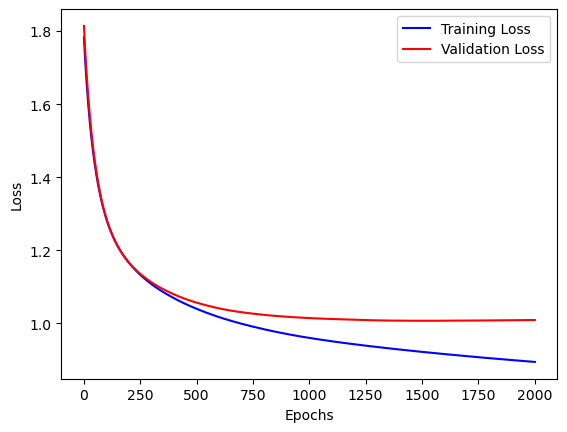

In [169]:


# possible values for activation functions = "tanh", "sigmoid", "relu", "identity", "softmax" 
#                                                                   for regression , for classification
# 
# possible values for optimizer = "sgd", "bgd", "mbgd"


# batch_size is only needed when optimizer is "mbgd"

# Mini-Batch Gradient Descent
# mbgd
# mlp = MLP(input_size=input_size, hidden_layer_sizes=[32, 32], output_size=output_size, \
#                     activation_function=["relu", "relu"], output_activation_function="softmax",\
#                         optimizer="mbgd", loss=CrossEntropyLoss(), learning_rate=0.01)
# mlp.train(X_train, y_train, X_val, y_val, epochs=10000, batch_size=32)

# Stochastic Gradient Descent
# sgd
# mlp = MLP(input_size=input_size, hidden_layer_sizes=[32, 32], output_size=output_size, \
#                     activation_function=["relu", "relu"], output_activation_function="softmax",\
#                         optimizer="sgd", loss=CrossEntropyLoss(), learning_rate=0.01)
# mlp.train(X_train, y_train, X_val, y_val, epochs=1000)

# Batch Gradient Descent
# bgd
mlp = MLP(input_size=input_size, hidden_layer_sizes=[32, 32], output_size=output_size, \
                    activation_function=["relu", "relu"], output_activation_function="softmax",\
                        optimizer="bgd", loss=CrossEntropyLoss(), learning_rate=0.01)
mlp.train(X_train, y_train, X_val, y_val, epochs=2000)

# print(len(mlp.hidden_layer_sizes))

# print(len(mlp.layers))


plt.plot(range(1, len(mlp.train_losses) + 1), mlp.train_losses, color='b', label='Training Loss')
plt.plot(range(1, len(mlp.val_losses) + 1), mlp.val_losses, color='r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Model Tuning and Hyperparameters

In [15]:
import numpy as np
import wandb
from sklearn.metrics import f1_score, precision_score, recall_score

# Import your custom classes and functions (e.g., MLP, loss functions) here

# Define a function to perform an experiment with given hyperparameters
def run_experiment(activation_function, optimizer, learning_rate, epochs, hidden_layer_neurons):
    # Initialize Weights & Biases for the experiment
    wandb.init(project="multi-layer-perceptron", config={
        "activation_function": activation_function,
        "optimizer": optimizer,
        "learning_rate": learning_rate,
        "epochs": epochs,
        "hidden_layer_neurons": hidden_layer_neurons
    })

    mlp = MLP(\
        input_size=input_size, \
            hidden_layer_sizes=hidden_layer_neurons, \
                output_size=output_size, \
                    activation_function=[activation_function, activation_function], \
                        output_activation_function="softmax", \
                            optimizer=optimizer, \
                                loss=CrossEntropyLoss(), \
                                    learning_rate=learning_rate)
    
    mlp.train(X_train, y_train, X_val, y_val, epochs=epochs)

    y_pred_val = mlp.predict(X_val)
    y_pred_train = mlp.predict(X_train)
    
    f1_train = f1_score(y_true = np.argmax(y_train , axis=1), y_pred= np.argmax(y_pred_train, axis=1), average='macro')
    precision_train = precision_score(y_true = np.argmax(y_train , axis=1), y_pred= np.argmax(y_pred_train, axis=1), average='macro', zero_division=0)
    recall_train = recall_score(y_true = np.argmax(y_train , axis=1), y_pred= np.argmax(y_pred_train, axis=1), average='macro')
    
    f1_val = f1_score(y_true = np.argmax(y_val , axis=1), y_pred= np.argmax(y_pred_val, axis=1), average='macro')
    precision_val = precision_score(y_true = np.argmax(y_val , axis=1), y_pred= np.argmax(y_pred_val, axis  = 1), average='macro', zero_division=0)
    recall_val = recall_score(y_true = np.argmax(y_val , axis=1), y_pred= np.argmax(y_pred_val, axis=1), average='macro')
    
    for epochs in range(len(mlp.train_losses)):
        wandb.log({
            "Training Loss": mlp.train_losses[epochs],
            "Validation Loss": mlp.val_losses[epochs],
            "Training Accuracy": mlp.train_accuracies[epochs],
            "Validation Accuracy": mlp.val_accuracies[epochs],
        })
    
    # Log metrics using W&B
    # wandb.log({
    #     "Training Loss": mlp.train_losses[-1],
    #     "Training Accuracy": mlp.train_accuracies[-1],
    #     "Validation Loss": mlp.val_losses[-1],
    #     "Validation Accuracy": mlp.val_accuracies[-1],
    #     "Training F1 Score": f1_train,
    #     "Training Precision": precision_train,
    #     "Training Recall": recall_train,
    #     "Validation F1 Score": f1_val,
    #     "Validation Precision": precision_val,
    #     "Validation Recall": recall_val
    # })

    # Finish the W&B run
    wandb.finish()

# Define hyperparameter search space
activation_functions = ["sigmoid", "tanh", "relu"]
optimizers = ["sgd", "bgd", "mbgd"]
learning_rates = [0.001, 0.01, 0.1]
epochs_values = [1000, 2000]
# hidden_layer_neurons_values = [[32, 32], [64, 64]]

# Loop over hyperparameter combinations
for activation_function in activation_functions:
    for optimizer in optimizers:
        for learning_rate in learning_rates:
            for epochs in epochs_values:
                for hidden_layer_neurons in [[32, 32], [64, 64], [32, 64]]:
                    run_experiment(activation_function, optimizer, learning_rate, epochs, hidden_layer_neurons)

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


ic| i: 1
ic| i: 2


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Training Accuracy,▁▅▅▅▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇███▇██████▇██
Training Loss,█▇▅▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁▅▃▆▆▇▇▇█▇█████▇▇▇▇▇▆▇▇▇▆▇▇▇▇▆▆▇▇▅▆▆▆▆▆▅
Validation Loss,█▇▄▃▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training Accuracy,0.6375
Training Loss,0.8671
Validation Accuracy,0.59302
Validation Loss,0.95303


ic| i: 1
ic| i: 2


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Training Accuracy,▁▄▄▅▆▅▆▆▆▆▇▆▆▇▆▆▅▇▆▇▇▇▇█▇▇▇▆▇█▇█▇▇▇█▇███
Training Loss,█▆▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Validation Accuracy,▁▆▄▇▅▆▇█▆▇▇█▇█▇▇▇▇█▇▇▇▇▆▇▇▇▅▇▆▆▆▇▆▆▇▇▇▅▆
Validation Loss,█▅▃▂▂▂▂▂▂▂▁▂▂▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂
Training Accuracy,0.64125
Training Loss,0.84735
Validation Accuracy,0.59884
Validation Loss,0.94509


ic| i: 1
ic| i: 2


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Training Accuracy,▁▅▅▆▇▇▇▇▇▇▇▇▇██▇▇▇█▇█▇█▇██▇██▇██████████
Training Loss,█▆▅▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁▄▅▇▆▆▇▇▇▇▇▆▇▇▇█▇▇▇▆▇█▇▆▇▇▇▆▇▇▇▇▇█▆▇▇▆▇▆
Validation Loss,█▅▃▂▂▂▂▂▁▂▂▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁
Training Accuracy,0.63875
Training Loss,0.85153
Validation Accuracy,0.59302
Validation Loss,0.93998


ic| i: 1
ic| i: 2


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Training Accuracy,▁▁▃▃▄▃▄▃▃▄▃▃▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▇▇█▇██▇█
Training Loss,█▅▅▅▅▄▄▄▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
Validation Accuracy,▁▂▇▇▇▅▆██▆▆▆▆▆▆▅▆▆▆▆▇▆▆█▆▆█▄▅▇██▆▆▆▄▅▆▅▅
Validation Loss,█▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄
Training Accuracy,0.70625
Training Loss,0.73009
Validation Accuracy,0.61047
Validation Loss,1.00321


ic| i: 1
ic| i: 2


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Training Accuracy,▁▃▄▄▄▄▄▄▄▅▄▅▅▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇███
Training Loss,█▆▅▅▅▅▅▅▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▁▁▁
Validation Accuracy,▁▅▇███▇▆▅▇█▅██▆▅▇▅▇▇█▆▄▅▇▆▆▆▆▄▅▆▆▅▄▄▅▇▄▄
Validation Loss,█▄▂▂▂▁▁▁▁▁▁▁▁▂▁▁▂▁▁▁▂▁▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆
Training Accuracy,0.74875
Training Loss,0.6655
Validation Accuracy,0.57558
Validation Loss,1.08074


ic| i: 1
ic| i: 2


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Training Accuracy,▁▄▄▄▅▄▄▄▄▅▅▄▅▄▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇█▇▇███
Training Loss,█▆▅▅▅▅▅▅▅▅▄▄▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
Validation Accuracy,▁▇▅▆▇▆▇█▇█▇▇▄▇▆▇▆▇▇▅▆▆▆▄▆▆▆▆▅▅▅▅▄▄▃▄▃▃▃▄
Validation Loss,▆▃▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▃▃▃▄▄▅▅▆▆▆▇▇▇██
Training Accuracy,0.7225
Training Loss,0.69677
Validation Accuracy,0.54651
Validation Loss,1.18027


ic| i: 1
ic| i: 2
/home/prakhar/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Training Accuracy,▁▂▁▂▂▂▃▃▃▃▄▄▄▅▄▅▅▅▆▆▆▇▇▇▇▇██████████████
Training Loss,██▇▇▇▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▆▆▄▄█▅▆▄▆▄▄▅▄▅▂▃▂▁▁▃▂▂▃▃▃▄▃▂▃▂▃▄▄▄▄▄▃▄▄▃
Validation Loss,▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▆▆▆▆▆▇▇▇▇████
Training Accuracy,0.99875
Training Loss,0.02324
Validation Accuracy,0.55814
Validation Loss,3.5345


ic| i: 1
ic| i: 2
/home/prakhar/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Training Accuracy,▁▁▂▁▂▂▂▃▃▃▃▄▅▅▆▆▆▇▇█████████████████████
Training Loss,██▇█▇▇▇▆▆▆▅▅▅▄▄▃▃▃▃▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▄▇▄▁▇▄▅▆▅▃▂▄▄▂▁▄▂▇▅█▅▇▆█▇▆▆▆▆▆▇▆▆▄▆▆▄▅▄▄
Validation Loss,▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▆▆▆▆▇▇▇▇▇█████
Training Accuracy,0.9975
Training Loss,0.00946
Validation Accuracy,0.59884
Validation Loss,3.51498


ic| i: 1
ic| i: 2
/home/prakhar/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Training Accuracy,▁▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇▇████████████████
Training Loss,█▇▇▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▆█▇▆█▅▅▅▄▄▄▃▁▃▂▂▂▄▅▄▃▅▃▅▄▅▄▅▄▄▅▄▄▄▄▄▅▄▄▅
Validation Loss,▁▁▁▁▁▁▁▁▁▁▁▂▂▂▃▃▃▄▄▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇██████
Training Accuracy,0.99875
Training Loss,0.0172
Validation Accuracy,0.56977
Validation Loss,4.5037


ic| i: 1
ic| i: 2


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Training Accuracy,▁▂▂▂▃▃▄▅▆▆▇▇████████████████████████████
Training Loss,█▇▇▇▆▆▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,█▅▅▆▅▃▅▄▁▂▃▂▃▃▃▃▂▃▃▃▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▂▃▂
Validation Loss,▁▁▁▁▁▁▂▂▂▃▃▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█████████
Training Accuracy,1.0
Training Loss,0.00393
Validation Accuracy,0.55814
Validation Loss,4.77907


ic| i: 1
ic| i: 2
/home/prakhar/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Training Accuracy,▁▁▁▂▂▂▄▅▆▇▇█████████████████████████████
Training Loss,██▇▇▇▆▅▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▆▆▄▅▆▁▄▅▄▅▅▆▆▆▆█▆▆▇▇██▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
Validation Loss,▁▁▁▁▁▂▂▂▂▃▃▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█████████
Training Accuracy,1.0
Training Loss,0.00176
Validation Accuracy,0.63953
Validation Loss,3.77145


ic| i: 1
ic| i: 2
/home/prakhar/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Training Accuracy,▁▁▂▂▂▃▄▄▆▆▇▇▇███████████████████████████
Training Loss,██▇▇▇▆▅▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▇█▇▇▆▁▃▃▅▅▅▇▇▆▅▇▆▇▆▆▇▇▆▆▇▆▆▆▇▆▆▇▆▆▇▇▇▇▇▇
Validation Loss,▁▁▁▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇██████████
Training Accuracy,1.0
Training Loss,0.00319
Validation Accuracy,0.59884
Validation Loss,4.73555


ic| i: 1
ic| i: 2


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Training Accuracy,▁▂▃▅▆▇██████████████████████████████████
Training Loss,█▇▆▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▇▆█▅▁▃▄▂▃▄▄▄▃▃▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▄▃▃▂▃▃▃▃▃▃
Validation Loss,▁▁▁▂▃▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█████████████████
Training Accuracy,1.0
Training Loss,0.00049
Validation Accuracy,0.5407
Validation Loss,4.78166


ic| i: 1
ic| i: 2
/home/prakhar/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Training Accuracy,▁▂▃▅▆███████████████████████████████████
Training Loss,█▇▆▄▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▇█▆▇▂▁▆█▅▆▆▆▆▆▆▆▆▅▆▅▅▅▅▅▅▆▆▆▆▅▅▅▇▆▆▅▆▆▇▇
Validation Loss,▁▁▁▂▃▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇████████████████
Training Accuracy,1.0
Training Loss,0.00031
Validation Accuracy,0.5814
Validation Loss,4.05757


ic| i: 1
ic| i: 2


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Training Accuracy,▁▁▂▄▄▆█▇████████████████████████████████
Training Loss,█▇▆▅▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▇▇▇▅▁▆█▆▆▇▇█▇▇▇▆▇▇▇▇▇▇▇▇▇▇▇██▇██████▇▇█▇
Validation Loss,▁▁▁▂▃▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█████████████████
Training Accuracy,1.0
Training Loss,0.00043
Validation Accuracy,0.61628
Validation Loss,4.1383


ic| i: 1
ic| i: 2
/home/prakhar/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Training Accuracy,▁▃▇█████████████████████████████████████
Training Loss,█▆▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁▆█▇▅▅▄▃▃▄▄▅▅▅▄▅▅▅▅▅▅▅▅▅▅▅▄▄▄▄▅▄▄▄▄▄▄▅▅▄
Validation Loss,▁▁▃▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███████████████████
Training Accuracy,1.0
Training Loss,0.00023
Validation Accuracy,0.59884
Validation Loss,4.60822


ic| i: 1
ic| i: 2


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Training Accuracy,▁▂▇█████████████████████████████████████
Training Loss,█▇▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▅▁▆▅▆▆▆▆▇▇███████████████████▇█▇▇▇█▇▇▇▇▇
Validation Loss,▁▂▃▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████████
Training Accuracy,1.0
Training Loss,0.00015
Validation Accuracy,0.59884
Validation Loss,4.31365


ic| i: 1
ic| i: 2


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Training Accuracy,▁▃▇█████████████████████████████████████
Training Loss,█▆▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,█▄▁▆▇▅▄▃▃▃▃▃▃▃▃▃▄▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
Validation Loss,▁▂▃▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████████
Training Accuracy,1.0
Training Loss,0.0002
Validation Accuracy,0.58721
Validation Loss,4.29357


ic| i: 1
ic| i: 2


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Training Accuracy,▁▁▁▁▁▁▂▃▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████▇▇▇
Training Loss,█▇▇▇▆▆▅▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁▁▁▁▁▁▂▃▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇███
Validation Loss,██▇▇▆▆▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
Training Accuracy,0.40875
Training Loss,1.28346
Validation Accuracy,0.48837
Validation Loss,1.2544


ic| i: 1
ic| i: 2


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Training Accuracy,▁▂▃▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████████
Training Loss,█▇▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁▁▄▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇▇████████████
Validation Loss,█▇▆▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training Accuracy,0.495
Training Loss,1.21513
Validation Accuracy,0.52326
Validation Loss,1.17113


ic| i: 1
ic| i: 2


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Training Accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▅▅▅▅▅▇▇▇▇▇█████
Training Loss,█▇▆▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█
Validation Loss,█▇▆▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training Accuracy,0.43125
Training Loss,1.21575
Validation Accuracy,0.47674
Validation Loss,1.18333


ic| i: 1
ic| i: 2


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Training Accuracy,▁▁▁▁▆▆▆▇▇▇████████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
Training Loss,█▇▆▅▅▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁▁▁▁▅▆▆▆▇███████████████████████████████
Validation Loss,█▇▆▅▅▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training Accuracy,0.46625
Training Loss,1.2057
Validation Accuracy,0.5
Validation Loss,1.16428


ic| i: 1
ic| i: 2


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Training Accuracy,▁▁▁▇▇▇▇▇▇▇▇▇▇▇▇█████████████████████████
Training Loss,█▆▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁▁▁██▇▇▇████████████████████████████████
Validation Loss,█▆▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training Accuracy,0.47375
Training Loss,1.18995
Validation Accuracy,0.5
Validation Loss,1.14932


ic| i: 1
ic| i: 2


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Training Accuracy,▁▁▁▁▁▁▁▁▁▂▅▆█▇▇▇▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇
Training Loss,█▆▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁▂▂▂▂▂▂▂▂▁▄▆██▇▇▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
Validation Loss,█▆▅▄▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training Accuracy,0.5
Training Loss,1.19073
Validation Accuracy,0.52326
Validation Loss,1.15246


ic| i: 1
ic| i: 2


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Training Accuracy,▁▁▁▃▃▃▄▃▄▄▄▅▅▆▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇███████
Training Loss,█▅▄▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▄▄▄▄▁▃▃▄▄▄▄▄▃▃▃▄▄▄▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇███
Validation Loss,█▅▄▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training Accuracy,0.49625
Training Loss,1.16807
Validation Accuracy,0.49419
Validation Loss,1.13474


ic| i: 1
ic| i: 2


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Training Accuracy,▁▁▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█▇▇██████
Training Loss,█▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁▁▃▃▃▃▃▃▃▄▄▅▅▅▅▄▄▄▅▅▅▅▆▆▆▆▅▅▆▇▇▇▇▇▇▇████
Validation Loss,█▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training Accuracy,0.54875
Training Loss,1.13672
Validation Accuracy,0.52326
Validation Loss,1.1061


ic| i: 1
ic| i: 2


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Training Accuracy,▁▂▂▂▃▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇█████████
Training Loss,█▄▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████████
Validation Loss,█▄▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training Accuracy,0.535
Training Loss,1.15885
Validation Accuracy,0.52326
Validation Loss,1.1175


ic| i: 1
ic| i: 2


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Training Accuracy,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█████
Training Loss,█▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▃▃▃▃▄▄▃▃▃▂▂▁▁▁▂▂▃▅▆▇▇▅▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇███
Validation Loss,█▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training Accuracy,0.55375
Training Loss,1.15178
Validation Accuracy,0.51744
Validation Loss,1.11985


ic| i: 1
ic| i: 2


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Training Accuracy,▁▄▄▄▄▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇█████████████
Training Loss,█▄▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁▂▄▅▆▆▅▅▅▅▅▅▅▆▅▅▅▆▇▇▇▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇███
Validation Loss,█▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
Training Accuracy,0.55625
Training Loss,1.08456
Validation Accuracy,0.54651
Validation Loss,1.0662


ic| i: 1
ic| i: 2


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Training Accuracy,▁▁▃▃▃▄▄▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████████
Training Loss,█▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▂▂▂▂▂▃▁▂▃▃▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████
Validation Loss,█▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
Training Accuracy,0.55875
Training Loss,1.11495
Validation Accuracy,0.56977
Validation Loss,1.07937


ic| i: 1
ic| i: 2


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Training Accuracy,▁▁▂▂▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇█████████
Training Loss,█▆▆▆▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁▂▂▃▃▃▃▃▄▄▃▃▄▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇████████
Validation Loss,█▆▆▆▆▅▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training Accuracy,0.61625
Training Loss,0.96591
Validation Accuracy,0.61047
Validation Loss,0.9621


ic| i: 1
ic| i: 2


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Training Accuracy,▁▃▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇███████████████████
Training Loss,█▇▇▆▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁▃▃▄▅▄▃▃▂▄▅▅▅▆▅▆▆▇▆▇▇▇▇▇▆▆▆▆▆██████▇████
Validation Loss,█▇▇▆▆▅▅▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training Accuracy,0.61125
Training Loss,0.95233
Validation Accuracy,0.62791
Validation Loss,0.9457


ic| i: 1
ic| i: 2


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Training Accuracy,▁▂▃▄▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇████████████
Training Loss,█▇▇▆▆▆▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁▂▂▂▃▅▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇███████████▇█
Validation Loss,█▇▇▆▆▆▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
Training Accuracy,0.615
Training Loss,0.96641
Validation Accuracy,0.62791
Validation Loss,0.96513


ic| i: 1
ic| i: 2


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Training Accuracy,▁▃▄▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇██████████████████████
Training Loss,█▇▇▆▆▅▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁▅▄▆██▇▇▆▆▇▇▇▇▇▇█████▇█▇▇▇▇████▇██▇▇▇▇▇▇
Validation Loss,█▇▆▆▅▅▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training Accuracy,0.625
Training Loss,0.94676
Validation Accuracy,0.60465
Validation Loss,0.94819


ic| i: 1
ic| i: 2


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Training Accuracy,▁▅▆▆▆▆▆▆▆▇▇▇▇▇█▇▇▇██████████████████████
Training Loss,█▇▆▆▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁▅▃▄▅▆▆▆▆▇▇▇▇▇▇▇▇█▇▇██████████▇███████▇▇
Validation Loss,█▇▆▅▅▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training Accuracy,0.625
Training Loss,0.93037
Validation Accuracy,0.61628
Validation Loss,0.93086


ic| i: 1
ic| i: 2


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Training Accuracy,▁▂▄▅▅▆▆▆▆▆▆▆▇▇▇▇▇███████████████████████
Training Loss,█▇▇▇▆▆▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁▂▃▂▃▅▅▆▆▆▆▇▇▇▇█▇██▇▇▇▇▇▇▇▇▇████████████
Validation Loss,█▇▇▆▆▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training Accuracy,0.6175
Training Loss,0.93803
Validation Accuracy,0.61047
Validation Loss,0.9447


ic| i: 1
ic| i: 2


TypeError: 'NoneType' object cannot be interpreted as an integer

In [35]:
mlp = MLP(\
        input_size=input_size, \
            hidden_layer_sizes=[32, 32], \
                output_size=output_size, \
                    activation_function=["relu", "relu"], \
                        output_activation_function="softmax", \
                            optimizer="bgd", \
                                loss=CrossEntropyLoss(), \
                                    learning_rate=0.001)
    
mlp.train(X_train, y_train, X_val, y_val, epochs=2000)

# y_pred_val = mlp.predict(X_val)
# y_pred_train = mlp.predict(X_train)
y_pred_test = mlp.predict(X_test)


f1_train = f1_score(y_true = np.argmax(y_test , axis=1), y_pred= np.argmax(y_pred_test, axis=1), average='macro')
precision_train = precision_score(y_true = np.argmax(y_test , axis=1), y_pred= np.argmax(y_pred_test, axis=1), average='macro', zero_division=0)
recall_train = recall_score(y_true = np.argmax(y_test , axis=1), y_pred= np.argmax(y_pred_test, axis=1), average='macro')

print("F1 Score: ", f1_train)
print("Precision: ", precision_train)
print("Recall: ", recall_train)

ic| i: 1
ic| i: 2


F1 Score:  0.25998052580331066
Precision:  0.23956894169660128
Recall:  0.2927120669056153


### For Regression

loss function -> mean squared error

output_size = 1

In [7]:
class MLP:
    def __init__(self, input_size, hidden_layer_sizes, output_size,\
                 activation_function, output_activation_function, optimizer, loss, learning_rate = 0.001) -> None:
        """
        input_size: number of features in the input
        
        hidden_layer_sizes: list of number of neurons in each hidden layer
        
        output_size: number of classes in the output
        
        activation_function: list of activation function for each layer
        
        learning_rate: learning rate for gradient 
        """
        
        self.act_dict = {
            "sigmoid": Sigmoid(),
            "tanh": Tanh(),
            "relu": ReLU(),
            "identity": Identity(),
            "softmax": Softmax()
        }
        
        
        # # initial plan was to implement classes for the optimizers
        # self.opt_dict = {
        #     "sgd": SGD(),
        #     "bgd": BGD(),
        #     "mbsgd" : MBGD()
        # }
        
                
        for act in activation_function:
            act = act.lower()
            
        self.optimizer = optimizer
        self.output_activation_function = output_activation_function
        
        self.layers = []
        # self.activation_function = []
        self.learning_rate = learning_rate
        self.loss = loss
        
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        
        self.train_rmse = []
        self.val_rmse = []
        self.train_mse = []
        self.val_mse = []
        self.train_r2_score = []
        self.val_r2_score = []
        
        # self.y_pred = None

        # initialize the input layer
        self.layers.append(InputLayer(input_size))
        
        hidden_layer_sizes.insert(0, input_size)
        # +1 for the ones we are inserting in X
        activation_function.insert(0, None)
        # ic(hidden_layer_sizes)
        
        self.hidden_layer_sizes = hidden_layer_sizes
        self.activation_function = activation_function
        
        for i in range(1, len(hidden_layer_sizes)):
            ic(i)
            self.layers.append(Layer(no_of_inputs=hidden_layer_sizes[i-1],no_of_neurons= hidden_layer_sizes[i], activation=self.act_dict[activation_function[i]]))

        self.layers.append(OutputLayer(hidden_layer_sizes[-1], output_size, self.act_dict[output_activation_function]))
        # print(len(self.layers))
    
    def forward_propagation(self, x)-> None:
        # Forward propagation
        for layer in self.layers:
            x = layer.forward(x)
        return x
        # return Softmax().activation(x)
        # return x
    
    # def backward_propagation(self, x, y)-> None:
    
    def backward_propagation(self, y_pred, y_true)-> None:
        # Forward propagation
        # self.forward_propagation(x)
        
        # calculate the loss gradient with respect to the output of the last layer
        # which is basically dj_dz for the output layer
        # delta_L represents delta for the last layer
        
        delta_L = self.loss.gradient(y_pred, y_true)
        # print(delta_L)
        # grad is dj_dz for the output layer
        # Backpropagation
        delta = delta_L
        # for layer in reversed(self.layers):
        #     delta = layer.backward(delta)
        # do the backword propagation for output layer explicitly and then the hidden layers and then for the input layer
        delta = self.layers[-1].backward(delta)
        # do the backword propagation for hidden layers
        for i in range(len(self.layers) - 2, 0, -1):
            delta = self.layers[i].backward(delta, self.layers[i+1].weights)
        # do the backword propagation for input layer
        delta = self.layers[0].backward(delta)
    
    def predict(self, x):
        # Forward propagation
        return self.forward_propagation(x)
    
    def update_weights(self):
        for layer in self.layers:
            layer.update_weights(self.learning_rate)
        
    
    # Working version of train
    # def train(self, X_train, y_train, X_val, y_val, epochs, batch_size):
    #     self.train_losses = []
    #     for epoch in range(epochs):
    #         loss = []
    #         for i in range(0, X_train.shape[0], batch_size):
    #             X_batch = X_train[i:i+batch_size]
    #             y_batch = y_train[i:i+batch_size]
    #             y_pred = self.forward_propagation(X_batch)
    #             self.backward_propagation(y_pred=y_pred, y_true=y_batch)
    #             self.update_weights()
    #             # calculate the loss
    #             loss.append(self.loss.loss(y_pred, y_batch))
    #         self.train_losses.append(np.mean(loss))
    
    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size=None):
        if self.optimizer == "bgd":
            self.train_bgd(X_train, y_train, X_val, y_val, epochs)
        if self.optimizer == "sgd":
            self.train_sgd(X_train, y_train, X_val, y_val, epochs)
        if self.optimizer == "mbgd":            
            self.train_mbgd(X_train, y_train, X_val, y_val, epochs, batch_size)
            
    def accuracy_helper(self, y_pred, y_true):
        return accuracy_score(y_true = np.argmax(y_true , axis=1), y_pred= np.argmax(y_pred, axis=1))
        
            
    def train_sgd(self, X_train, y_train, X_val, y_val, epochs):
        for epoch in range(epochs):
            # generate a random index
            for i in range(X_train.shape[0]):
                k = np.random.randint(0, X_train.shape[0])
                X_batch = X_train[k:k+1]
                y_batch = y_train[k:k+1]
                y_pred = self.forward_propagation(X_batch)
                self.backward_propagation(y_pred=y_pred, y_true=y_batch)
                self.update_weights()
            # calculate the loss for the entire training set
            y_pred_train = self.forward_propagation(X_train)
            # print(y_pred_train)
            
            loss_train = self.loss.loss(y_pred_train, y_train)
            self.train_losses.append(loss_train)
            if self.output_activation_function == "softmax":
                acc_train = self.accuracy_helper(y_pred_train, y_train)
                self.train_accuracies.append(acc_train)
            elif self.output_activation_function == "identity":
                # calculate RMSE MSE and R-Square
                # print(y_pred_train)
                self.train_mse.append(mean_squared_error(y_train, y_pred_train))
                self.train_rmse.append(np.sqrt(mean_squared_error(y_train, y_pred_train)))
                self.train_r2_score.append(r2_score(y_train, y_pred_train))
            
            if X_val is not None and y_val is not None:
                y_pred_val = self.forward_propagation(X_val)
                
                loss_val = self.loss.loss(y_pred_val, y_val)
                self.val_losses.append(loss_val)
                if self.output_activation_function == "softmax":
                    val_acc = self.accuracy_helper(y_pred_val, y_val)
                    self.val_accuracies.append(val_acc)
                elif self.output_activation_function == "identity":
                    self.val_mse.append(mean_squared_error(y_val, y_pred_val))
                    self.val_rmse.append(np.sqrt(mean_squared_error(y_val, y_pred_val)))
                    self.val_r2_score.append(r2_score(y_val, y_pred_val))
                    
        
            
    def train_bgd(self, X_train, y_train, X_val, y_val, epochs):
        for epoch in range(epochs):
            y_pred = self.forward_propagation(X_train)
            self.backward_propagation(y_pred=y_pred, y_true=y_train)
            self.update_weights()
            # calculate the loss for the entire training set
            y_pred_train = self.forward_propagation(X_train)
            
            loss_train = self.loss.loss(y_pred_train, y_train)
            self.train_losses.append(loss_train)
            if self.output_activation_function == "softmax":
                train_acc = self.accuracy_helper(y_pred_train, y_train)
                self.train_accuracies.append(train_acc)
            elif self.output_activation_function == "identity":
                # calculate RMSE MSE and R-Square
                self.train_mse.append(mean_squared_error(y_train, y_pred_train))
                self.train_rmse.append(np.sqrt(mean_squared_error(y_train, y_pred_train)))
                self.train_r2_score.append(r2_score(y_train, y_pred_train))
            
            if X_val is not None and y_val is not None:
                y_pred_val = self.forward_propagation(X_val)
                
                loss_val = self.loss.loss(y_pred_val, y_val)
                self.val_losses.append(loss_val)
                if self.output_activation_function == "softmax":
                    val_acc = self.accuracy_helper(y_pred_val, y_val)
                    self.val_accuracies.append(val_acc)
                elif self.output_activation_function == "identity":
                    self.val_mse.append(mean_squared_error(y_val, y_pred_val))
                    self.val_rmse.append(np.sqrt(mean_squared_error(y_val, y_pred_val)))
                    self.val_r2_score.append(r2_score(y_val, y_pred_val))
            
    
    def train_mbgd(self, X_train, y_train, X_val, y_val, epochs, batch_size):
        for epoch in range(epochs):
            for i in range(0, X_train.shape[0], batch_size):
                X_batch = X_train[i:i+batch_size]
                y_batch = y_train[i:i+batch_size]
                y_pred = self.forward_propagation(X_batch)
                self.backward_propagation(y_pred=y_pred, y_true=y_batch)
                self.update_weights()
            # calculate the loss for the entire training set
            y_pred_train = self.forward_propagation(X_train)
            
            loss_train = self.loss.loss(y_pred_train, y_train)
            self.train_losses.append(loss_train)
            if self.output_activation_function == "softmax":
                train_acc = self.accuracy_helper(y_pred_train, y_train)
                self.train_accuracies.append(train_acc)
            elif self.output_activation_function == "identity":
                # calculate RMSE MSE and R-Square
                self.train_mse.append(mean_squared_error(y_train, y_pred_train))
                self.train_rmse.append(np.sqrt(mean_squared_error(y_train, y_pred_train)))
                self.train_r2_score.append(r2_score(y_train, y_pred_train))
            
            if X_val is not None and y_val is not None:
                y_pred_val = self.forward_propagation(X_val)
                loss_val = self.loss.loss(y_pred_val, y_val)
                self.val_losses.append(loss_val)
                if self.output_activation_function == "softmax":
                    val_acc = self.accuracy_helper(y_pred_val, y_val)
                    self.val_accuracies.append(val_acc)           
                elif self.output_activation_function == "identity":
                    self.val_mse.append(mean_squared_error(y_val, y_pred_val))
                    self.val_rmse.append(np.sqrt(mean_squared_error(y_val, y_pred_val)))
                    self.val_r2_score.append(r2_score(y_val, y_pred_val))
            
            


In [8]:
PATH_HOUSING = "./dataset/HousingData.csv"
df = pd.read_csv(PATH_HOUSING)

In [9]:
df.isnull().sum()

CRIM       20
ZN         20
INDUS      20
CHAS       20
NOX         0
RM          0
AGE        20
DIS         0
RAD         0
TAX         0
PTRATIO     0
B           0
LSTAT      20
MEDV        0
dtype: int64

In [10]:
# fill the nan values 
# except for the CHAS column it is a categorical variable
df["CHAS"] = df.CHAS.fillna(df.CHAS.mode()[0])
df = df.fillna(df.mean())

In [11]:
df.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

In [12]:
# standardize the data except the target column 'MEDV' and "CHAS"
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df.drop(['MEDV', 'CHAS'], axis=1))
df_scaled = pd.DataFrame(df_scaled, columns=df.drop(["CHAS", "MEDV"], axis=1).columns)
df_scaled["CHAS"] = df["CHAS"]

In [13]:
X = df_scaled.values
y = df["MEDV"].values

input_size = X.shape[1]

# because it's regression
output_size = 1

In [14]:
# split into train test and validation test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5)

In [15]:
y_train.shape, y_test.shape, y_val.shape

((354,), (76,), (76,))

Add new axis to y_train, y_test and y_val

In [16]:
y_test = y_test.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)

In [17]:
y_train.shape, y_test.shape, y_val.shape

((354, 1), (76, 1), (76, 1))

In [18]:
regression = MLP(\
    input_size=input_size,\
        hidden_layer_sizes=[32, 64],\
            output_size=output_size, activation_function=["tanh", "tanh"],\
                output_activation_function="identity",\
                    optimizer="sgd",\
                        loss = MSELoss(),\
                            learning_rate=0.001)

regression.train(X_train, y_train, X_val, y_val, epochs = 2000)

ic| i: 1
ic| i: 2


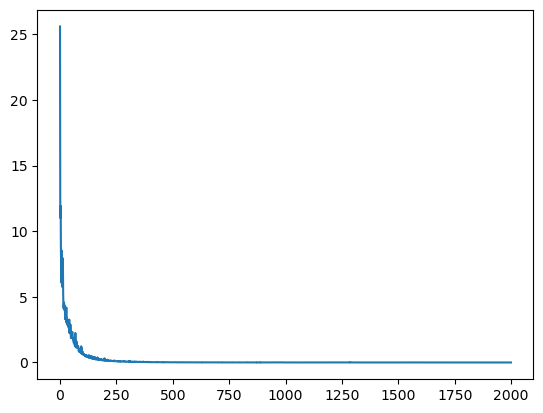

In [19]:
plt.plot(regression.train_losses, label="Training Loss")

In [20]:
import numpy as np
import wandb
from sklearn.metrics import f1_score, precision_score, recall_score

# Import your custom classes and functions (e.g., MLP, loss functions) here

# Define a function to perform an experiment with given hyperparameters
def run_experiment(activation_function, optimizer, learning_rate, epochs, hidden_layer_neurons):
    # Initialize Weights & Biases for the experiment
    wandb.init(project="multi-layer-regression", config={
        "activation_function": activation_function,
        "optimizer": optimizer,
        "learning_rate": learning_rate,
        "epochs": epochs,
        "hidden_layer_neurons": hidden_layer_neurons
    })

    mlp = MLP(\
        input_size=input_size, \
            hidden_layer_sizes=hidden_layer_neurons, \
                output_size=output_size, \
                    activation_function=[activation_function, activation_function], \
                        output_activation_function="identity", \
                            optimizer=optimizer, \
                                loss=MSELoss(), \
                                    learning_rate=learning_rate)
    
    mlp.train(X_train, y_train, X_val, y_val, epochs=epochs)

    y_pred_val = mlp.predict(X_val)
    y_pred_train = mlp.predict(X_train)
    

    for epochs in range(len(mlp.train_losses)):
        wandb.log({
            # "Training Loss": mlp.train_losses[epochs],
            "Validation Loss": mlp.val_losses[epochs],
            # "Training Accuracy": mlp.train_accuracies[epochs],
            # "Validation Accuracy": mlp.val_accuracies[epochs],
        })
    
    # Log metrics using W&B
    # wandb.log({
    #     "Training Loss": mlp.train_losses[-1],
    #     "Training Accuracy": mlp.train_accuracies[-1],
    #     "Validation Loss": mlp.val_losses[-1],
    #     "Validation Accuracy": mlp.val_accuracies[-1],
    #     "Training F1 Score": f1_train,
    #     "Training Precision": precision_train,
    #     "Training Recall": recall_train,
    #     "Validation F1 Score": f1_val,
    #     "Validation Precision": precision_val,
    #     "Validation Recall": recall_val
    # })

    # Finish the W&B run
    wandb.finish()

# Define hyperparameter search space
activation_functions = ["sigmoid", "tanh", "relu"]
optimizers = ["sgd", "bgd", "mbgd"]
learning_rates = [0.001, 0.01, 0.1]
epochs_values = [1000, 2000]
# hidden_layer_neurons_values = [[32, 32], [64, 64]]

# Loop over hyperparameter combinations
for activation_function in activation_functions:
    for optimizer in optimizers:
        for learning_rate in learning_rates:
            for epochs in epochs_values:
                for hidden_layer_neurons in [[32, 32], [64, 64], [32, 64]]:
                    run_experiment(activation_function, optimizer, learning_rate, epochs, hidden_layer_neurons)

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


ic| i: 1
ic| i: 2


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Validation Loss,█▅▅▃▃▂▂▂▂▂▂▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
Validation Loss,17.90009


ic| i: 1
ic| i: 2


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Validation Loss,█▅▄▃▂▃▂▃▂▂▁▁▁▂▁▁▂▁▁▁▁▂▂▂▁▂▂▁▂▂▁▂▂▁▂▁▁▁▂▂
Validation Loss,19.52876


ic| i: 1
ic| i: 2


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Validation Loss,█▅▄▃▃▂▂▂▂▁▂▂▂▁▂▁▁▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂
Validation Loss,20.20855


ic| i: 1
ic| i: 2


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Validation Loss,█▅▃▃▃▂▂▂▁▁▁▂▂▃▃▃▄▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
Validation Loss,25.84228


ic| i: 1
ic| i: 2


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Validation Loss,█▅▃▅▄▃▂▂▁▁▂▁▂▁▁▂▂▂▂▃▃▄▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▅▆▆
Validation Loss,26.57557


ic| i: 1
ic| i: 2


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Validation Loss,█▃▁▂▂▂▂▂▃▂▃▂▂▂▂▂▂▂▃▃▃▃▂▃▃▃▃▃▃▃▃▃▃▃▃▂▃▂▃▂
Validation Loss,22.80357


ic| i: 1
ic| i: 2


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Validation Loss,█▅▅▆▄▄▃▃▂▂▂▂▁▁▂▂▁▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
Validation Loss,27.93359


ic| i: 1
ic| i: 2


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Validation Loss,█▅▄▃▂▂▂▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▃▂▂▂▂▂▃▃▃▃▂▂▂▂▃▂▂▂
Validation Loss,19.13187


ic| i: 1
ic| i: 2


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Validation Loss,█▄▂▃▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Loss,18.72893


ic| i: 1
ic| i: 2


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Validation Loss,█▃▄▅▄▅▅▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁
Validation Loss,19.72867


ic| i: 1
ic| i: 2


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Validation Loss,█▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Loss,22.92155


ic| i: 1
ic| i: 2


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Validation Loss,█▁▁▁▁▁▁▂▂▂▃▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
Validation Loss,21.04242


ic| i: 1
ic| i: 2
/tmp/ipykernel_84218/3803969322.py:5: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/tmp/ipykernel_84218/3803969322.py:5: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/tmp/ipykernel_84218/3803969322.py:5: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/tmp/ipykernel_84218/3803969322.py:5: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/tmp/ipykernel_84218/3803969322.py:5: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/tmp/ipykernel_84218/3803969322.py:5: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/tmp/ipykernel_84218/3803969322.py:5: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/tmp/ipykernel_84218/3803969322.py:5: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/tmp/ipykernel_84218/3803969322.py:5: RuntimeWarning: overflow encountered in exp
  re

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Validation Loss,▅▂▃▁▁▃▅▅▅▆▆▄▅▅▅▄▅▆▆▅▅▅▅▄▅▅▅▄▆▅▅▅▅▆▅▅█▅▄▅
Validation Loss,123.3553


ic| i: 1
ic| i: 2
/tmp/ipykernel_84218/3803969322.py:5: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/tmp/ipykernel_84218/3803969322.py:5: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/tmp/ipykernel_84218/3803969322.py:5: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/tmp/ipykernel_84218/3803969322.py:5: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/tmp/ipykernel_84218/3803969322.py:5: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/tmp/ipykernel_84218/3803969322.py:5: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/tmp/ipykernel_84218/3803969322.py:5: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/tmp/ipykernel_84218/3803969322.py:5: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/tmp/ipykernel_84218/3803969322.py:5: RuntimeWarning: overflow encountered in exp
  re

ValueError: Input contains NaN.

# For multi-label classification

In [6]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler

In [7]:
class MLP:
    def __init__(self, input_size, hidden_layer_sizes, output_size,\
                 activation_function, output_activation_function, optimizer, loss, learning_rate = 0.001) -> None:
        """
        input_size: number of features in the input
        
        hidden_layer_sizes: list of number of neurons in each hidden layer
        
        output_size: number of classes in the output
        
        activation_function: list of activation function for each layer
        
        learning_rate: learning rate for gradient 
        """
        
        self.act_dict = {
            "sigmoid": Sigmoid(),
            "tanh": Tanh(),
            "relu": ReLU(),
            "identity": Identity(),
            "softmax": Softmax()
        }
        
        
        # # initial plan was to implement classes for the optimizers
        # self.opt_dict = {
        #     "sgd": SGD(),
        #     "bgd": BGD(),
        #     "mbsgd" : MBGD()
        # }
        
                
        for act in activation_function:
            act = act.lower()
            
        self.optimizer = optimizer
        self.output_activation_function = output_activation_function
        
        self.layers = []
        # self.activation_function = []
        self.learning_rate = learning_rate
        self.loss = loss
        
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        
        self.train_rmse = []
        self.val_rmse = []
        self.train_mse = []
        self.val_mse = []
        self.train_r2_score = []
        self.val_r2_score = []
        
        # self.y_pred = None

        # initialize the input layer
        self.layers.append(InputLayer(input_size))
        
        hidden_layer_sizes.insert(0, input_size)
        # +1 for the ones we are inserting in X
        activation_function.insert(0, None)
        # ic(hidden_layer_sizes)
        
        self.hidden_layer_sizes = hidden_layer_sizes
        self.activation_function = activation_function
        
        for i in range(1, len(hidden_layer_sizes)):
            ic(i)
            self.layers.append(Layer(no_of_inputs=hidden_layer_sizes[i-1],no_of_neurons= hidden_layer_sizes[i], activation=self.act_dict[activation_function[i]]))

        self.layers.append(OutputLayer(hidden_layer_sizes[-1], output_size, self.act_dict[output_activation_function]))
        # print(len(self.layers))
    
    def forward_propagation(self, x)-> None:
        # Forward propagation
        for layer in self.layers:
            x = layer.forward(x)
        return x
        # return Softmax().activation(x)
        # return x
    
    # def backward_propagation(self, x, y)-> None:
    
    def backward_propagation(self, y_pred, y_true)-> None:
        # Forward propagation
        # self.forward_propagation(x)
        
        # calculate the loss gradient with respect to the output of the last layer
        # which is basically dj_dz for the output layer
        # delta_L represents delta for the last layer
        
        delta_L = self.loss.gradient(y_pred, y_true)
        # print(delta_L)
        # grad is dj_dz for the output layer
        # Backpropagation
        delta = delta_L
        # for layer in reversed(self.layers):
        #     delta = layer.backward(delta)
        # do the backword propagation for output layer explicitly and then the hidden layers and then for the input layer
        delta = self.layers[-1].backward(delta)
        # do the backword propagation for hidden layers
        for i in range(len(self.layers) - 2, 0, -1):
            delta = self.layers[i].backward(delta, self.layers[i+1].weights)
        # do the backword propagation for input layer
        delta = self.layers[0].backward(delta)
    
    def predict(self, x):
        # Forward propagation
        return self.forward_propagation(x)
    
    def update_weights(self):
        for layer in self.layers:
            layer.update_weights(self.learning_rate)
        
    
    # Working version of train
    # def train(self, X_train, y_train, X_val, y_val, epochs, batch_size):
    #     self.train_losses = []
    #     for epoch in range(epochs):
    #         loss = []
    #         for i in range(0, X_train.shape[0], batch_size):
    #             X_batch = X_train[i:i+batch_size]
    #             y_batch = y_train[i:i+batch_size]
    #             y_pred = self.forward_propagation(X_batch)
    #             self.backward_propagation(y_pred=y_pred, y_true=y_batch)
    #             self.update_weights()
    #             # calculate the loss
    #             loss.append(self.loss.loss(y_pred, y_batch))
    #         self.train_losses.append(np.mean(loss))
    
    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size=None):
        if self.optimizer == "bgd":
            self.train_bgd(X_train, y_train, X_val, y_val, epochs)
        if self.optimizer == "sgd":
            self.train_sgd(X_train, y_train, X_val, y_val, epochs)
        if self.optimizer == "mbgd":            
            self.train_mbgd(X_train, y_train, X_val, y_val, epochs, batch_size)
            
    def accuracy_helper(self, y_pred, y_true):
        return accuracy_score(y_true = np.argmax(y_true , axis=1), y_pred= np.argmax(y_pred, axis=1))
        
            
    def train_sgd(self, X_train, y_train, X_val, y_val, epochs):
        for epoch in range(epochs):
            # generate a random index
            for i in range(X_train.shape[0]):
                k = np.random.randint(0, X_train.shape[0])
                X_batch = X_train[k:k+1]
                y_batch = y_train[k:k+1]
                y_pred = self.forward_propagation(X_batch)
                self.backward_propagation(y_pred=y_pred, y_true=y_batch)
                self.update_weights()
            # calculate the loss for the entire training set
            y_pred_train = self.forward_propagation(X_train)
            
            loss_train = self.loss.loss(y_pred_train, y_train)
            self.train_losses.append(loss_train)
            if self.output_activation_function == "softmax":
                acc_train = self.accuracy_helper(y_pred_train, y_train)
                self.train_accuracies.append(acc_train)
            elif self.output_activation_function == "identity":
                # calculate RMSE MSE and R-Square
                self.train_mse(mean_squared_error(y_train, y_pred_train))
                self.train_rmse(np.sqrt(mean_squared_error(y_train, y_pred_train)))
                self.train_r2_score(r2_score(y_train, y_pred_train))
            
            if X_val is not None and y_val is not None:
                y_pred_val = self.forward_propagation(X_val)
                
                loss_val = self.loss.loss(y_pred_val, y_val)
                self.val_losses.append(loss_val)
                if self.output_activation_function == "softmax":
                    val_acc = self.accuracy_helper(y_pred_val, y_val)
                    self.val_accuracies.append(val_acc)
                elif self.output_activation_function == "identity":
                    self.val_mse(mean_squared_error(y_val, y_pred_val))
                    self.val_rmse(np.sqrt(mean_squared_error(y_val, y_pred_val)))
                    self.vaval_r2_score(r2_score(y_val, y_pred_val))
                    
        
            
    def train_bgd(self, X_train, y_train, X_val, y_val, epochs):
        for epoch in range(epochs):
            y_pred = self.forward_propagation(X_train)
            self.backward_propagation(y_pred=y_pred, y_true=y_train)
            self.update_weights()
            # calculate the loss for the entire training set
            y_pred_train = self.forward_propagation(X_train)
            
            loss_train = self.loss.loss(y_pred_train, y_train)
            self.train_losses.append(loss_train)
            if self.output_activation_function == "softmax":
                train_acc = self.accuracy_helper(y_pred_train, y_train)
                self.train_accuracies.append(train_acc)
            elif self.output_activation_function == "identity":
                # calculate RMSE MSE and R-Square
                self.train_mse(mean_squared_error(y_train, y_pred_train))
                self.train_rmse(np.sqrt(mean_squared_error(y_train, y_pred_train)))
                self.train_r2_score(r2_score(y_train, y_pred_train))
            
            if X_val is not None and y_val is not None:
                y_pred_val = self.forward_propagation(X_val)
                
                loss_val = self.loss.loss(y_pred_val, y_val)
                self.val_losses.append(loss_val)
                if self.output_activation_function == "softmax":
                    val_acc = self.accuracy_helper(y_pred_val, y_val)
                    self.val_accuracies.append(val_acc)
                elif self.output_activation_function == "identity":
                    self.val_mse(mean_squared_error(y_val, y_pred_val))
                    self.val_rmse(np.sqrt(mean_squared_error(y_val, y_pred_val)))
                    self.val_r2_score(r2_score(y_val, y_pred_val))
            
    
    def train_mbgd(self, X_train, y_train, X_val, y_val, epochs, batch_size):
        for epoch in range(epochs):
            for i in range(0, X_train.shape[0], batch_size):
                X_batch = X_train[i:i+batch_size]
                y_batch = y_train[i:i+batch_size]
                y_pred = self.forward_propagation(X_batch)
                self.backward_propagation(y_pred=y_pred, y_true=y_batch)
                self.update_weights()
            # calculate the loss for the entire training set
            y_pred_train = self.forward_propagation(X_train)
            
            loss_train = self.loss.loss(y_pred_train, y_train)
            self.train_losses.append(loss_train)
            if self.output_activation_function == "softmax":
                train_acc = self.accuracy_helper(y_pred_train, y_train)
                self.train_accuracies.append(train_acc)
            elif self.output_activation_function == "identity":
                # calculate RMSE MSE and R-Square
                self.train_mse(mean_squared_error(y_train, y_pred_train))
                self.train_rmse(np.sqrt(mean_squared_error(y_train, y_pred_train)))
                self.train_r2_score(r2_score(y_train, y_pred_train))
            
            if X_val is not None and y_val is not None:
                y_pred_val = self.forward_propagation(X_val)
                loss_val = self.loss.loss(y_pred_val, y_val)
                self.val_losses.append(loss_val)
                if self.output_activation_function == "softmax":
                    val_acc = self.accuracy_helper(y_pred_val, y_val)
                    self.val_accuracies.append(val_acc)           
                elif self.output_activation_function == "identity":
                    self.val_mse(mean_squared_error(y_val, y_pred_val))
                    self.val_rmse(np.sqrt(mean_squared_error(y_val, y_pred_val)))
                    self.val_r2_score(r2_score(y_val, y_pred_val))
            
            


In [8]:
df = pd.read_csv("./dataset/advertisement.csv")
df.head()

,age,gender,income,education,married,children,city,occupation,purchase_amount,most bought item,labels
0,45,Male,61271.953359,Master,False,3,Lake Sheila,Doctor,87.697118,monitor,electronics clothing sports
1,24,Female,53229.101074,High School,False,1,Crystalburgh,Businessman,115.135586,lipstick,furniture beauty
2,45,Female,30066.046684,Bachelor,True,3,Margaretburgh,Engineer,101.694559,biscuits,clothing electronics food sports
3,19,Male,48950.246384,PhD,False,0,Williamshaven,Lawyer,97.964887,maggi,food
4,29,Female,44792.627094,Master,False,0,New Paul,Businessman,86.847281,carpet,home


In [9]:
# no point in using city the number of dimensions will increase exponentially

In [10]:
print(df.city.value_counts())

city
Michaelberg     3
East John       3
West Robert     2
New Kathryn     2
North Andrew    2
               ..
Rosstown        1
Kevintown       1
Kirkland        1
New Monica      1
Port Jose       1
Name: count, Length: 969, dtype: int64


In [11]:
mlb = MultiLabelBinarizer()

df_multioutput = df.copy()
# X_dt = df_multioutput.drop(['labels', 'city'], axis=1).apply(lambda col: le_multioutput.transform(col) if col.name not in ['income'] else col)
# X_dt = df_multioutput['gender', 'education', 'married', 'occupation', 'most bought item'].get_dummies()
X_dt = df_multioutput[['age', 'gender', 'income', 'education', 'married',
                       'children',  'occupation', 'purchase_amount', 'most bought item']]
columnx = ['gender', 'education', 'married', 'occupation', 'most bought item']
X_dt = pd.get_dummies(X_dt, columns=columnx)
y_dt = mlb.fit_transform(
    df_multioutput['labels'].apply(lambda x: np.sort(x.split())))


# replace true and false values with 1 and zero
X_dt = X_dt.replace(True, 1)
X_dt = X_dt.replace(False, 0)

y_dt = y_dt.astype(float)

scaler = StandardScaler()

X_dt["income"] = scaler.fit_transform(df["income"].values.reshape(-1, 1))
X_dt["age"] = scaler.fit_transform(df["age"].values.reshape(-1, 1))
X_dt["purchase_amount"] = scaler.fit_transform(df["purchase_amount"].values.reshape(-1, 1))



X_train, X_test, y_train, y_test = train_test_split(
    X_dt, y_dt, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

In [14]:
input_size = X_train.shape[1]
output_size = y_train.shape[1]

In [17]:
import numpy as np
import wandb
from sklearn.metrics import f1_score, precision_score, recall_score

# Import your custom classes and functions (e.g., MLP, loss functions) here

# Define a function to perform an experiment with given hyperparameters
def run_experiment(activation_function, optimizer, learning_rate, epochs, hidden_layer_neurons):
    # Initialize Weights & Biases for the experiment
    wandb.init(project="multi-layer-multi-label", config={
        "activation_function": activation_function,
        "optimizer": optimizer,
        "learning_rate": learning_rate,
        "epochs": epochs,
        "hidden_layer_neurons": hidden_layer_neurons
    })

    mlp = MLP(\
        input_size=input_size, \
            hidden_layer_sizes=hidden_layer_neurons, \
                output_size=output_size, \
                    activation_function=[activation_function, activation_function], \
                        output_activation_function="softmax", \
                            optimizer=optimizer, \
                                loss=CrossEntropyLoss(), \
                                    learning_rate=learning_rate)
    
    mlp.train(X_train, y_train, X_val, y_val, epochs=epochs)

    y_pred_val = mlp.predict(X_val)
    y_pred_train = mlp.predict(X_train)
    
    f1_train = f1_score(y_true = np.argmax(y_train , axis=1), y_pred= np.argmax(y_pred_train, axis=1), average='macro')
    precision_train = precision_score(y_true = np.argmax(y_train , axis=1), y_pred= np.argmax(y_pred_train, axis=1), average='macro', zero_division=0)
    recall_train = recall_score(y_true = np.argmax(y_train , axis=1), y_pred= np.argmax(y_pred_train, axis=1), average='macro')
    
    f1_val = f1_score(y_true = np.argmax(y_val , axis=1), y_pred= np.argmax(y_pred_val, axis=1), average='macro')
    precision_val = precision_score(y_true = np.argmax(y_val , axis=1), y_pred= np.argmax(y_pred_val, axis  = 1), average='macro', zero_division=0)
    recall_val = recall_score(y_true = np.argmax(y_val , axis=1), y_pred= np.argmax(y_pred_val, axis=1), average='macro')
    
    for epochs in range(len(mlp.train_losses)):
        wandb.log({
            "Training Loss": mlp.train_losses[epochs],
            "Validation Loss": mlp.val_losses[epochs],
            "Training Accuracy": mlp.train_accuracies[epochs],
            "Validation Accuracy": mlp.val_accuracies[epochs],
        })
    
    # Log metrics using W&B
    wandb.log({
        "Training Loss": mlp.train_losses[-1],
        "Training Accuracy": mlp.train_accuracies[-1],
        "Validation Loss": mlp.val_losses[-1],
        "Validation Accuracy": mlp.val_accuracies[-1],
        "Training F1 Score": f1_train,
        "Training Precision": precision_train,
        "Training Recall": recall_train,
        "Validation F1 Score": f1_val,
        "Validation Precision": precision_val,
        "Validation Recall": recall_val
    })

    # Finish the W&B run
    wandb.finish()

# Define hyperparameter search space
activation_functions = ["sigmoid", "tanh", "relu"]
optimizers = ["sgd", "bgd", "mbgd"]
learning_rates = [0.001, 0.01, 0.1]
epochs_values = [1000, 2000]
# hidden_layer_neurons_values = [[32, 32], [64, 64]]

# Loop over hyperparameter combinations
for activation_function in activation_functions:
    for optimizer in optimizers:
        for learning_rate in learning_rates:
            for epochs in epochs_values:
                for hidden_layer_neurons in [[32, 32], [64, 64], [32, 64]]:
                    run_experiment(activation_function, optimizer, learning_rate, epochs, hidden_layer_neurons)

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


ic| i: 1
ic| i: 2
